In [1]:
import os

USE_LOCAL_RUNTIME = True

if USE_LOCAL_RUNTIME:
#     os.chdir('/home/tom/Workspace/hypeminer/misc/optimisation')
    os.chdir('C:/Users/Agando/Workspace/hypeminer/misc/optimisation') 
else:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/hypeminer/training-data/optimisation')

In [37]:
import json
import pandas as pd
from datetime import datetime
from IPython.display import display
import requests

symbol = 'BNBUSDT'
start = '20200101000000'
freq = 5
days = 365

# strategy = 'MACDDPeaks'
strategy = 'MACDDPnL'
# strategy = 'MACDVigano'

# ---------------------------------------------------------

FEES = 0.001

def to_datetime(timestamp):
    return datetime(
      int(timestamp[0:4]), int(timestamp[4:6]), int(timestamp[6:8]), 
      int(timestamp[8:10]), int(timestamp[10:12]), int(timestamp[12:14])
  )

def get_value(v):
    try:
        return float(v['value'])
    except:
        return float(v['value'][0][1])

def load_file(file):
    df = pd.DataFrame()
    with open(file) as f:
        data = json.load(f)
    df['ds'] = [datetime.strptime(v['timestamp'], '%Y-%m-%d %H:%M:%S') for v in data]
    df['open'] = [get_value(v) for v in data]
    return df

def display_whole(dframe):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(dframe)

strategies = {
    'MACDDPnL': "MACD Diff Peak&Limit",
    'MACDDPeaks': "MACD Diff Peaks",
    'MACDVigano': "MACD Viganò HistoCross"
}

run_id = f"{symbol}-{start}-{freq}-{days}-{strategy}"
run_title = f"{symbol} - {strategies[strategy]} at {days} days from " \
            f"{to_datetime(start).strftime('%Y-%m-%d')} every {freq} minutes"
file = f"{symbol}-{start}-{freq}-{days}.json"

to_interval = {
    1: '1m',
    3: '3m',
    5: '5m',
    15: '15m',
    30: '30m',
    60: '1h',
    120: '2h',
    240: '4h',
    360: '6h',
    480: '8h',
    720: '12h',
    1440: '1d',
    4320: '3d',
    10080: '1w',
}

def to_epoch(timestamp, milliseconds=True):
    dt = to_datetime(timestamp)
    epoch = dt.timestamp()
    if milliseconds:
        return int(epoch * 1000)
    else:
        return int(epoch)
    
def to_readable(epoch):
    return datetime.fromtimestamp(epoch/1000).strftime('%Y-%m-%d %H:%M:%S')

BINANCE_URL = "https://api.binance.com/api/v3/klines?symbol={}&interval={}&limit={}&startTime={}"

def fetch(symbol, epoch, interval="1m", limit=1):
    response = requests.request("GET", BINANCE_URL.format(symbol, interval, limit, epoch))
    result = json.loads(response.text)
    return result
    
def download_history_fast(symbol, start, delta_minutes=60, days=90):
    millis_in_period = days * 24 * 60 * 60 * 1000
    file_dest = f"{symbol}-{start}-{delta_minutes}-{days}.json"
    if os.path.isfile(file_dest):
        return
    epoch = to_epoch(start)
    epoch_at_start = epoch
    interval = to_interval[delta_minutes]
    values = []
    i = 0
    completed = False
    while not completed:
        values_batch = fetch(symbol, epoch, interval=interval, limit=1000)
        for value in values_batch:
            obj = {"index": i, "timestamp": to_readable(value[0]), "value": value[1]}
            values.append(obj)
            i += 1
            if value[0] >= epoch_at_start + millis_in_period:
                completed = True
                break
        print(f"Fetched {len(values)} values at {to_readable(epoch)}...")
        epoch += 1000 * delta_minutes * 60000

    with open(file_dest, 'w') as f_out:
        json.dump(values, f_out)

download_history_fast(symbol, start, delta_minutes=freq, days=days)

In [38]:
df_orig = load_file(file)
df_orig

,ds,open
0,2020-01-01 00:00:00,13.7159
1,2020-01-01 00:05:00,13.7010
2,2020-01-01 00:10:00,13.7125
3,2020-01-01 00:15:00,13.7051
4,2020-01-01 00:20:00,13.7024
...,...,...
105116,2020-12-30 23:40:00,38.0611
105117,2020-12-30 23:45:00,38.2087
105118,2020-12-30 23:50:00,38.1183
105119,2020-12-30 23:55:00,38.0900


In [39]:
# exponential moving average
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

df_orig['ema12'] = ema(df_orig['open'], 12)
df_orig['ema26'] = ema(df_orig['open'], 26)
df_orig['macd'] = df_orig['ema12'] - df_orig['ema26']
df_orig['signal'] = ema(df_orig['macd'], 9)
df_orig['macddiff'] = df_orig['macd'] - df_orig['signal']
# df_orig['macddiff'] = 1000 * (df_orig['macd'] - df_orig['signal']) / df_orig['open']

df_orig

,ds,open,ema12,ema26,macd,signal,macddiff
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374
...,...,...,...,...,...,...,...
105116,2020-12-30 23:40:00,38.0611,37.865194,37.818075,0.047120,0.028692,0.018427
105117,2020-12-30 23:45:00,38.2087,37.918041,37.847010,0.071032,0.037160,0.033871
105118,2020-12-30 23:50:00,38.1183,37.948850,37.867105,0.081745,0.046077,0.035668
105119,2020-12-30 23:55:00,38.0900,37.970566,37.883616,0.086950,0.054252,0.032698


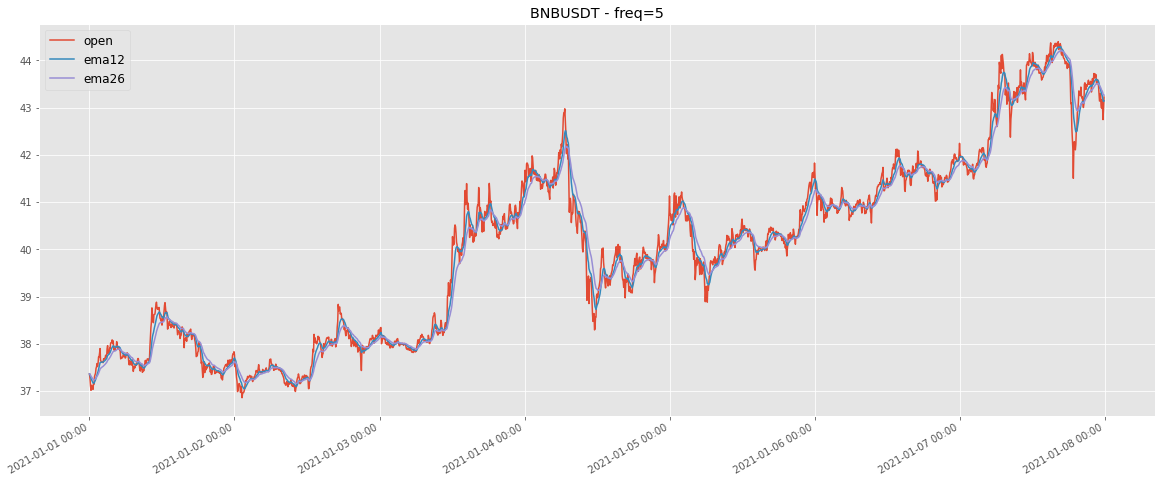

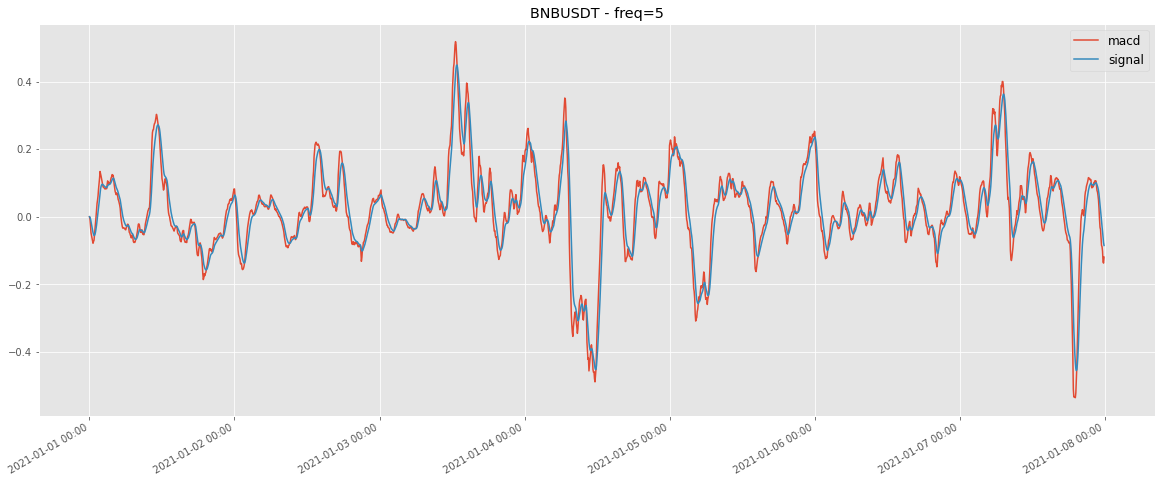

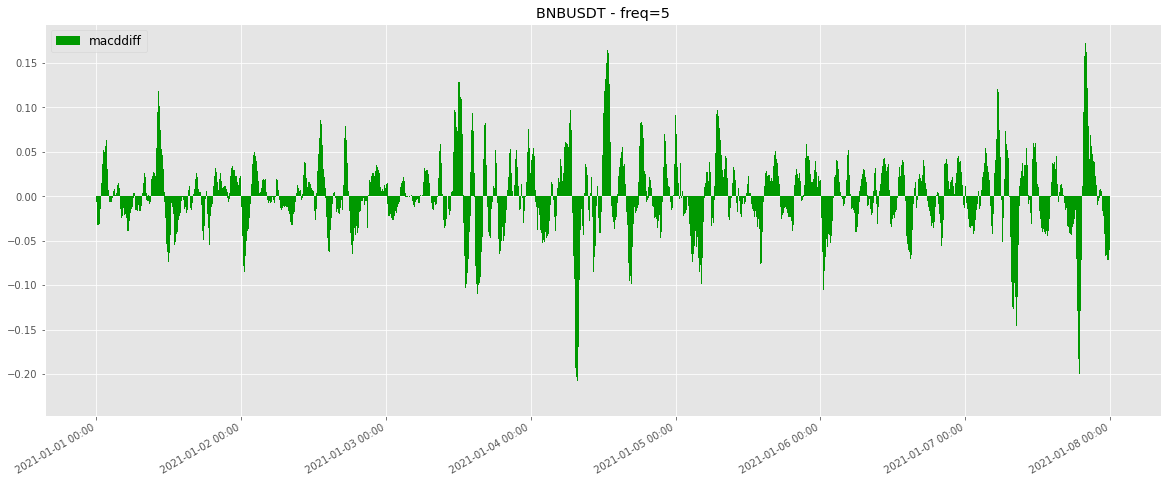

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

def plot(typ, df_plot, cols, title=None, baseline=None):
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    for col in cols:
        if typ == 'line':
            plt.plot(df_plot['ds'], df_plot[col], label=col)
        elif typ == 'bars':
            plt.bar(df_plot['ds'], df_plot[col], color='#009900', label=col, width=.005)
    if baseline:
        try:
            for bl in baseline:
                plt.axhline(y=bl, color='b', linestyle='-', label='baseline')
        except:
            plt.axhline(y=baseline, color='b', linestyle='-', label='baseline')
    plt.legend(loc="best", prop={'size': 12})
    if not title:
        title = f"{symbol} - freq={freq}"
    plt.title(title)
    plt.gcf().autofmt_xdate()
    plt.show()

samples = int(7 * 24 * 60 / 5)
dfs = df_orig.iloc[:samples]

plot('line', dfs, ['open', 'ema12', 'ema26'])
plot('line', dfs, ['macd', 'signal'])
plot('bars', dfs, ['macddiff'])

In [40]:
df_orig['prev_open'] = df_orig['open'].shift(1)

df_orig['is_negative'] = df_orig['macddiff'] < 0
df_orig['is_upward'] = df_orig['macddiff'].diff() > 0

df_orig.iloc[:30]

,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,is_upward
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000,NaN,False,False
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951,13.7159,True,False
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761,13.7010,True,True
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070,13.7125,True,False
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374,13.7051,True,False
5,2020-01-01 00:25:00,13.7023,13.709369,13.712270,-0.002901,-0.001411,-0.001489,13.7024,True,False
6,2020-01-01 00:30:00,13.7038,13.708512,13.711642,-0.003130,-0.001755,-0.001375,13.7023,True,True
7,2020-01-01 00:35:00,13.7042,13.707849,13.711091,-0.003242,-0.002053,-0.001190,13.7038,True,True
8,2020-01-01 00:40:00,13.7002,13.706672,13.710284,-0.003612,-0.002365,-0.001248,13.7042,True,False
9,2020-01-01 00:45:00,13.7043,13.706307,13.709841,-0.003534,-0.002598,-0.000936,13.7002,True,True


In [7]:
def compute_macd_vigano_histocross(df_orig, verbose=False, plot_chart=False):
    
    df = df_orig.copy()

    df['prev_is_negative'] = df['is_negative'].shift(1)
    
    df['suggest'] = 'IDLE'
    df.loc[(df['is_negative'] == False) & (df['prev_is_negative'] == True), 'suggest'] = 'BUY'
    df.loc[(df['is_negative'] == True) & (df['prev_is_negative'] == False), 'suggest'] = 'SELL'

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1

    assets_values = []
    actions = []
    investment = None
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY':
            s = 'IN'
            actions.append('BUY')
            assets = assets * (1 - FEES)
            investment = assets
        elif s == 'IN' and row['suggest'] == 'SELL' and assets * (1-FEES) > investment:
            s = 'OUT'
            actions.append('SELL')
            assets = assets * (1 - FEES)
        else:
            actions.append('----')
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display_whole(df[:100])
    
    if plot_chart:
        df['buy-and-hold'] = df['open'] / df['open'].iloc[0]
        plot('line', df, ['assets', 'buy-and-hold'], title=f"{symbol} - {strategies[strategy]}")
    
    return assets, bnh    


if strategy == 'MACDVigano':
    compute_macd_vigano_histocross(df_orig, verbose=True, plot_chart=True)

In [8]:
def compute_macd_diff_peaks(df_orig, thr, verbose=False, plot_chart=False):
    
    df = df_orig.copy()

    df['suggest'] = 'IDLE'
    df.loc[df['is_negative'] & df['is_upward'], 'suggest'] = 'BUY'
    df.loc[(df['is_negative'] == False) & (df['is_upward'] == False), 'suggest'] = 'SELL'

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1

    assets_values = []
    actions = []
    investment = None
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY' and row['macddiff'] < -thr:
            s = 'IN'
            actions.append('BUY')
            assets = assets * (1 - FEES)
            investment = assets
        elif s == 'IN' and row['suggest'] == 'SELL' and row['macddiff'] > thr and assets * (1-FEES) > investment:
            s = 'OUT'
            actions.append('SELL')
            assets = assets * (1 - FEES)
        else:
            actions.append('----')
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display_whole(df[:100])
    
    if plot_chart:
        df['buy-and-hold'] = df['open'] / df['open'].iloc[0]
        plot('line', df, ['assets', 'buy-and-hold'], title=f"{symbol} - {strategies[strategy]}")
    
    return assets, bnh    


if strategy == 'MACDDPeaks':
    results = {}
    for i in range(0, 11):
        thr = i / 10
        assets, bnh = compute_macd_diff_peaks(df_orig, thr)
        print((thr, assets))
        results[thr] = assets
    best_thr = sorted(results.items(), key=lambda x: x[1], reverse=True)[0][0]
    print(f"Best threshold: {best_thr}")
    compute_macd_diff_peaks(df_orig, best_thr, verbose=True, plot_chart=True)

In [54]:
def compute_macd_diff_peak_and_limit(df_orig, take_profit=None, stop_loss=None, verbose=False, plot_chart=False):
    
    df = df_orig.copy()

    if take_profit and stop_loss: # static values
        df['take_profit'] = take_profit
        df['stop_loss'] = stop_loss
    else:
        assert 'take_profit' in df and 'stop_loss' in df

    df['suggest'] = 'IDLE'
    df.loc[df['is_negative'] & df['is_upward'], 'suggest'] = 'BUY'

    df['limit'] = 0
    df.loc[df['suggest'] == 'BUY', 'limit'] = df['open'] * df['take_profit']

    df['stop'] = 0
    df.loc[df['suggest'] == 'BUY', 'stop'] = df['open'] * df['stop_loss']

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1
    limit = None
    stop = None

    assets_values = []
    actions = []
    results = []
    invest = []
    investment = None
    investment_when = None
    invest_when = []
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY':
            s = 'IN'
            limit = row['limit']
            stop = row['stop']
            actions.append('BUY')
            assets = assets * (1 - FEES)
            investment = assets
            investment_when = row['ds']
            results.append(np.nan)
            invest.append(np.nan)
            invest_when.append(np.nan)
        elif s == 'IN' and (row['open'] * (1-FEES) - limit >= 0 or row['open'] <= stop):
            s = 'OUT'
            limit = None
            stop = None
            actions.append('SELL')
            assets = assets * (1 - FEES)
            results.append('GAIN' if assets >= investment else 'LOSS')
            invest.append(investment)
            invest_when.append(investment_when)
        else:
            actions.append('----')
            results.append(np.nan)
            invest.append(np.nan)
            invest_when.append(np.nan)
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    df['result'] = results
    df['invest'] = invest
    df['invest-when'] = invest_when
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display(df[:30])
    
    if plot_chart:
        df['buy-and-hold'] = df['open'] / df['open'].iloc[0]
        plot('line', df, ['assets', 'buy-and-hold'], title=f"{symbol} - {strategies[strategy]} take_profit={take_profit} stop_loss={stop_loss}")
    
    return assets, bnh, df

In [60]:
import numpy as np
import matplotlib.colors as colors
from joblib import Parallel, delayed
import multiprocessing

LIMIT_RANGE = [101, 111, 1]
STOP_LOSS_RANGE = [80, 99, 2]


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def build_heatmap(heat, file_id, xs, ys, fig_file=None):
    info = file_id.split('-')

    X, Y = np.meshgrid(xs, ys)
    Z = np.array(heat['stake']).reshape(X.shape)
    bnh = heat['baseline'].iloc[-1]

    # heatmap
    plt.rcParams["figure.figsize"] = (20, 12)
    plt.xticks(range(len(xs)), [f"+{(x-1)*100:.0f}%" for x in xs])
    plt.yticks(range(len(ys)), [f"-{(1-y)*100:.0f}%" for y in ys])
    plt.grid(False)
    plt.title(run_title)
    plt.xlabel('take_profit')
    plt.ylabel('stop_loss')
    heat = plt.imshow(Z, cmap='RdBu', norm=MidpointNormalize(midpoint=bnh))
    plt.colorbar(heat)
    if not os.path.exists(f"plots/{info[4]}"):
        os.makedirs(f"plots/{info[4]}")
    if not fig_file:
        fig_file = f"plots/{info[4]}/{file_id}.png"
    plt.savefig(fig_file)
    plt.show()

def optimise(df_opt, run_id, tsv_file=None):
        
    if not tsv_file:
        tsv_file = f"{run_id}.tsv"
        
    print(f"started: {run_id}")
    
    # limit
    # xs = np.arange(101, 121, 1) / 100
    xs = np.arange(LIMIT_RANGE[0], LIMIT_RANGE[1]+1, LIMIT_RANGE[2]) / 100
    # stop_loss
    # ys = np.arange(80, 100, 1) / 100
    ys = np.arange(STOP_LOSS_RANGE[0], STOP_LOSS_RANGE[1]+1, STOP_LOSS_RANGE[2]) / 100

    if not os.path.isfile(tsv_file):
        heat = pd.DataFrame()
        take_profits, stop_losses, baselines, stakes = [], [], [], []
        for stop_loss in ys:
            for take_profit in xs:
                stake, baseline, _ = compute_macd_diff_peak_and_limit(df_opt, take_profit=take_profit, stop_loss=stop_loss)
                print("\t".join(["{:.2f}".format(x) for x in [take_profit, stop_loss, baseline, stake]]).expandtabs(8))
                take_profits.append(take_profit)
                stop_losses.append(stop_loss)
                baselines.append(baseline)
                stakes.append(stake)
        heat['target'] = take_profits
        heat['stop_loss'] = stop_losses
        heat['baseline'] = baselines
        heat['stake'] = stakes
        heat.to_csv(tsv_file, sep='\t', index=False)
    else:
        heat = pd.read_csv(tsv_file, sep='\t')
    
    return heat, xs, ys

In [57]:
# if strategy == 'MACDDPnL':
#     heat, xs, ys = optimise(df_orig, run_id)    
#     display_whole(heat)
    
#     build_heatmap(heat, run_id, xs, ys)
    
#     best_take_profit, best_stop_loss, _, _, = heat.sort_values(by='stake', ascending=False).iloc[0]

#     _, _, df_strategy = compute_macd_diff_peak_and_limit(
#         df_orig, best_take_profit, best_stop_loss, verbose=False, plot_chart=True)

In [13]:
df_strategy['result-perc'] = (df_strategy['assets'] / df_strategy['invest'] - 1) * 100

display_whole(df_strategy[(df_strategy['result'] == 'GAIN') | (df_strategy['result'] == 'LOSS')])

,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,is_upward,suggest,limit,stop,assets,action,result,invest,invest-when,buy-and-hold,result-perc
726,2021-01-03 12:30:00,40.5163,39.878408,39.370729,0.507679,0.398709,0.108970,40.4443,False,False,IDLE,0.000000,0.00000,1.089354,SELL,GAIN,0.999000,2021-01-01 00:20:00,1.084495,9.044478
1807,2021-01-07 06:35:00,43.9604,43.174982,42.864758,0.310224,0.250998,0.059225,43.4002,False,True,IDLE,0.000000,0.00000,1.196143,SELL,GAIN,1.088265,2021-01-03 13:20:00,1.176683,9.912827
2923,2021-01-11 03:35:00,39.0750,40.215655,40.707871,-0.492216,-0.339340,-0.152875,39.5928,True,False,IDLE,0.000000,0.00000,1.071766,SELL,LOSS,1.194947,2021-01-07 08:05:00,1.045916,-10.308427
4048,2021-01-15 01:20:00,42.3919,42.119123,41.891129,0.227994,0.231416,-0.003422,42.2162,True,True,BUY,46.207171,38.15271,1.169965,SELL,GAIN,1.070695,2021-01-11 03:50:00,1.134699,9.271570
4850,2021-01-17 20:10:00,46.1888,45.595925,45.150501,0.445424,0.392565,0.052859,45.7653,False,True,IDLE,0.000000,0.00000,1.274356,SELL,GAIN,1.168795,2021-01-15 01:25:00,1.236330,9.031605
5421,2021-01-19 19:45:00,41.8017,42.477079,42.881349,-0.404270,-0.380511,-0.023759,42.4135,True,False,IDLE,0.000000,0.00000,1.141110,SELL,LOSS,1.273082,2021-01-17 20:55:00,1.118901,-10.366288
6052,2021-01-22 00:20:00,38.0064,38.590974,38.908753,-0.317779,-0.259578,-0.058201,38.2462,True,False,IDLE,0.000000,0.00000,1.021471,SELL,LOSS,1.139969,2021-01-19 19:50:00,1.017313,-10.394842
6230,2021-01-22 15:10:00,41.2412,40.905445,40.782651,0.122794,0.120595,0.002199,40.8416,False,True,IDLE,0.000000,0.00000,1.114313,SELL,GAIN,1.020450,2021-01-22 00:40:00,1.103898,9.198263
8499,2021-01-30 12:15:00,44.4988,43.996320,43.857484,0.138836,0.092366,0.046471,44.2598,False,True,IDLE,0.000000,0.00000,1.218852,SELL,GAIN,1.113199,2021-01-22 15:55:00,1.191094,9.490926


In [ ]:
OPT_WINDOW_DAYS = 60

obj_list = []
for t_days in range(16, 21):
    opt_start = int(60 / freq) * 24 * t_days
    opt_end = int(60 / freq) * 24 * (t_days + OPT_WINDOW_DAYS)
    df_test = df_orig.iloc[opt_start : opt_end]
    file_id = f"window-test/{start[:4]}_ow{OPT_WINDOW_DAYS}_t{t_days}"
    obj_list.append({'df': df_test, 'start': df_test['ds'].iloc[0], 'end': df_test['ds'].iloc[-1], 'id': file_id})

results = Parallel(n_jobs=multiprocessing.cpu_count())(
    delayed(optimise)(
        df_opt=x['df'], run_id=run_id, tsv_file=f"{x['id']}.tsv"
    ) for x in obj_list)

for x, (heat, xs, ys) in zip(obj_list, results):
    print(x)
    build_heatmap(heat, run_id, xs, ys, fig_file=f"{x['id']}.png")    

start_date: 2020-01-16 00:00:00
end_date: 2020-03-15 23:55:00
file_id: window-test/2020_ow60_t15


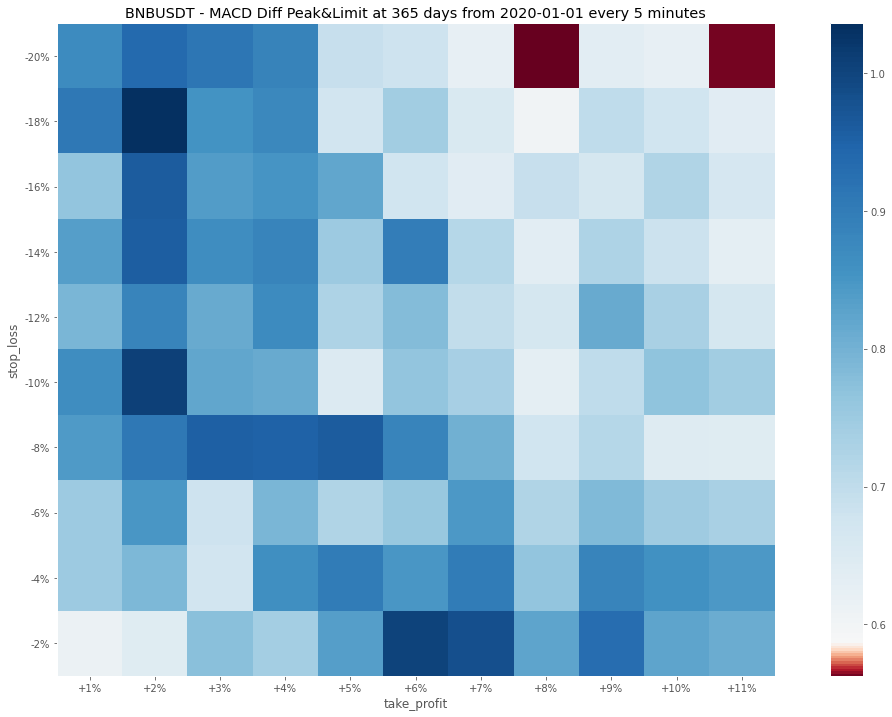

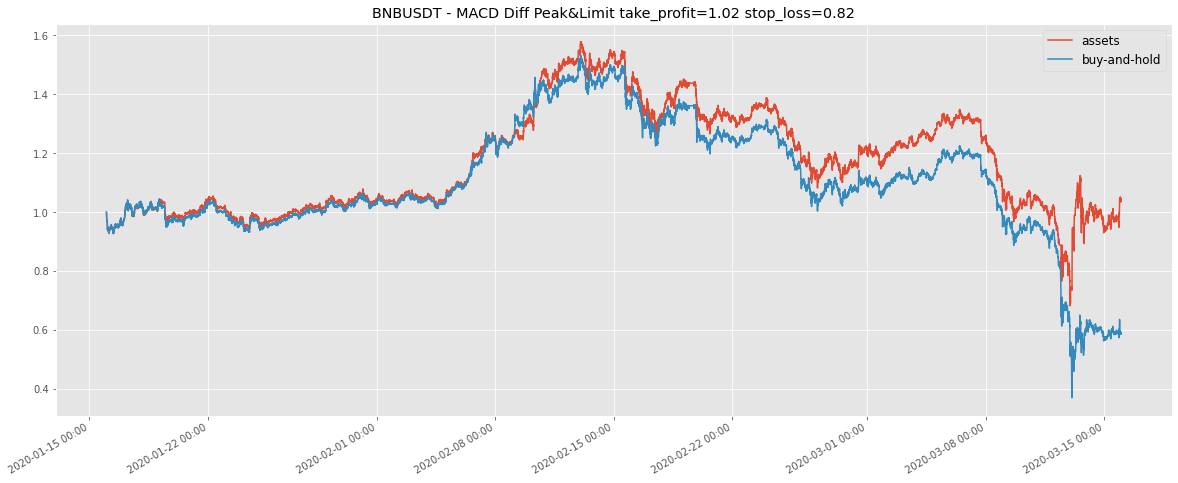

In [62]:
for t_days in range(15, 16):
    opt_start = int(60 / freq) * 24 * t_days
    opt_end = int(60 / freq) * 24 * (t_days + OPT_WINDOW_DAYS)
    df_test = df_orig.iloc[opt_start : opt_end]
    print(f"start_date: {df_test['ds'].iloc[0]}\nend_date: {df_test['ds'].iloc[-1]}")

    file_id = f"window-test/{start[:4]}_ow{OPT_WINDOW_DAYS}_t{t_days}"
    print(f"file_id: {file_id}")
    heat, xs, ys = optimise(df_test, run_id, tsv_file=f"{file_id}.tsv")    
#     display_whole(heat)

    build_heatmap(heat, run_id, xs, ys, fig_file=f"{file_id}.png")

    best_target, best_stop_loss, _, _, = heat.sort_values(by='stake', ascending=False).iloc[0]

    _, _, df_strategy = compute_macd_diff_peak_and_limit(
        df_test, best_target, best_stop_loss, verbose=False, plot_chart=True)

## 10-day optimisation

Judging by the heatmaps, it look like the optimisation window is too short for a reliable result.

### 1 Jan to 11 Jan

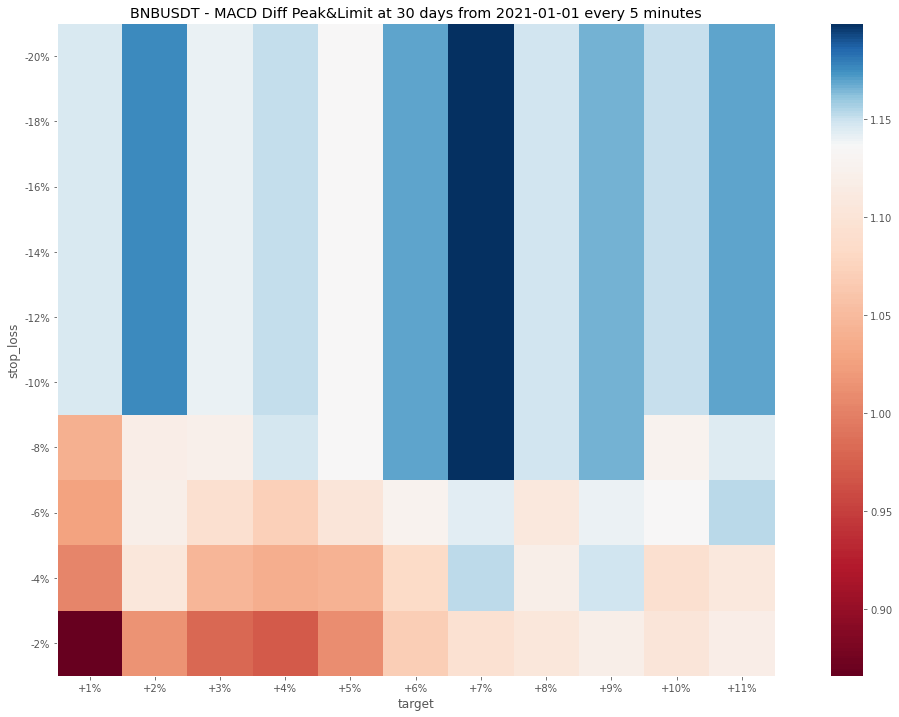

### 11 Jan to 21 Jan

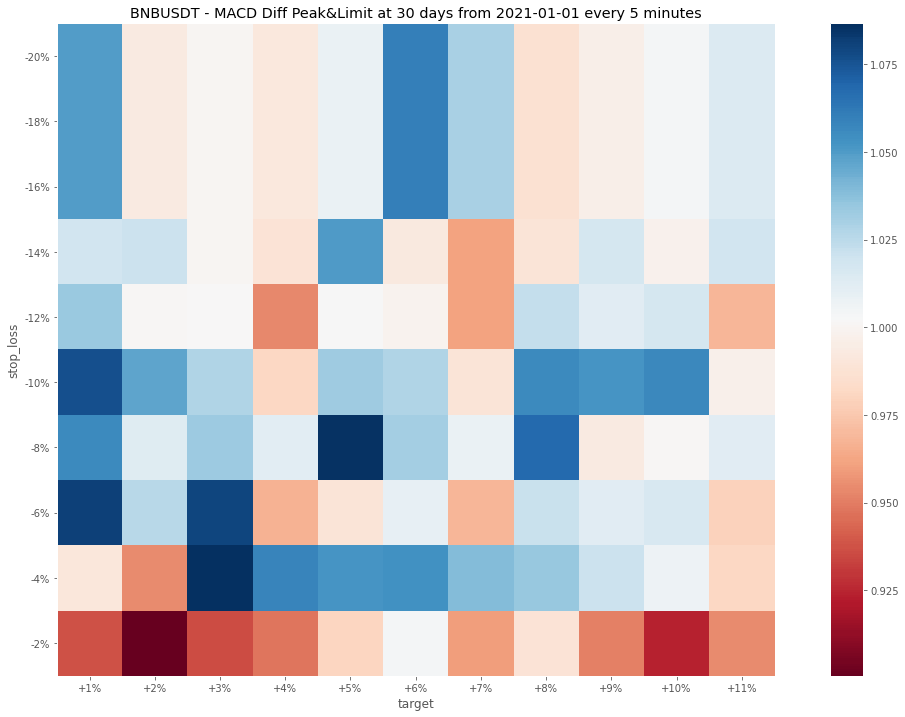

### 21 Jan to 31 Jan

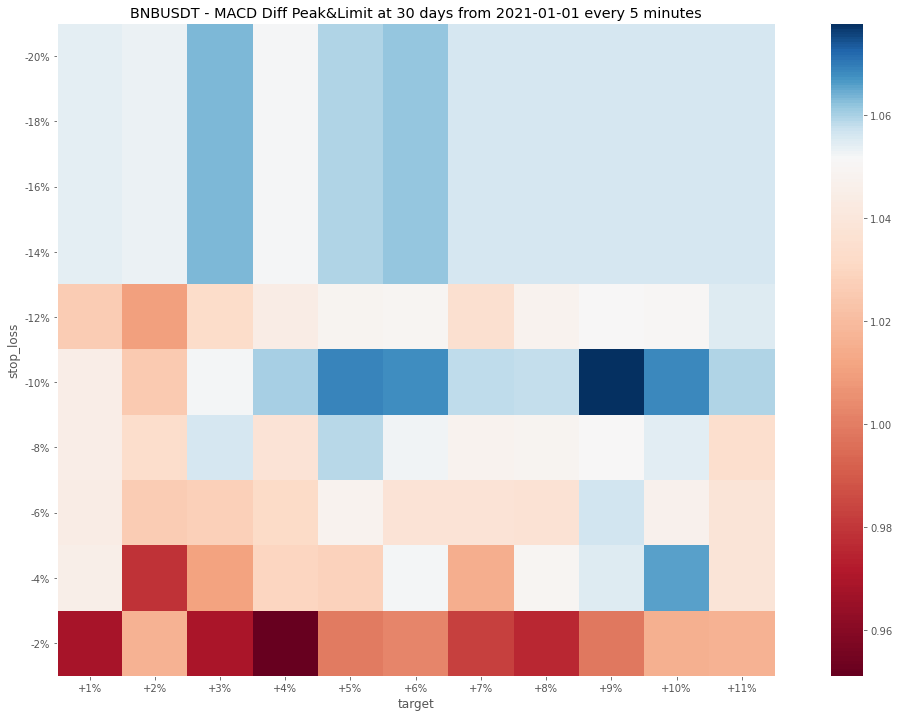